<a href="https://colab.research.google.com/github/JoDeMiro/Micado-Research/blob/main/ML_Auto_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Micado Auto Scale Research

Ebben a felskálázási adatok elemzésével foglalkozom.

Ez az interkatív bemutató arra van, hogy a válotzók közötti összefüggéseket jobban átlásssam, elemezzem, az esetleges anomáliákat rögtön kiszúrjam.

A playground részben a rendszer alapját adó neuráli háló beállításaival lehet játszani és megfigyelni, hogy milyen hatással van a rendszer teljesítményére.

<a name="tartalom"></a>

## Tartalom

Bevezetés

> [Empty](#empty)<br>
> [Play Ground](#play_ground)<br>
> [SandBox](#sandbox)<br>
> [Before After](#beforeafter)<br>
> [Szintetikus adatok generálása](#szintetikus_adatok)<br>
> [Irodalom](#irodalom)<br>
> [ToDo](#todo)<br>


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

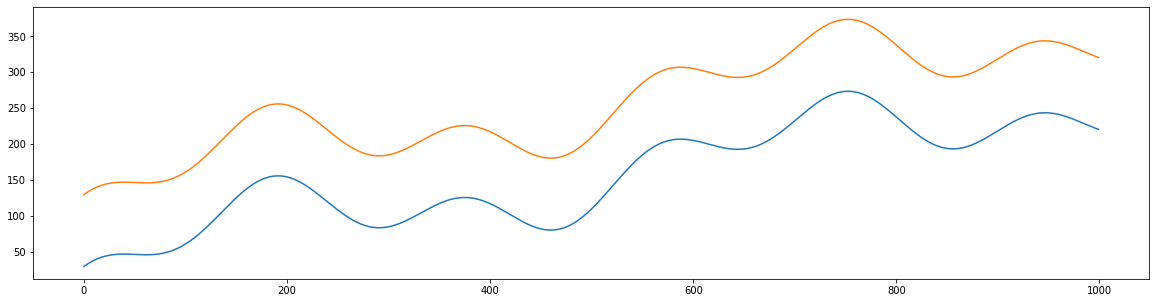

In [2]:
distance   = np.arange(0, 1000, 1)
road       = 100
wall_left  = 30*(np.sin(distance/180)) + distance * 0.3 + 30 * np.cos(distance/30) + 50 * np.sin(distance/90)
wall_right = wall_left + road

plt.figure(figsize=(20,5)); plt.plot(distance, wall_left); plt.plot(wall_right); plt.show()

In [3]:
class Road():
  def __init__(self):
    self.distance   = np.arange(0, 1000, 1)
    self.road       = 100
    self.wall_right = 30*(np.sin(self.distance/180)) + self.distance * 0.3 + 30 * np.cos(self.distance/30) + 50 * np.sin(self.distance/90)
    self.wall_left  = self.wall_right + self.road

  def show(self):
    fig, ax = plt.subplots(figsize=(20,5)); ax.set_ylim(0, 400); ax.plot(self.wall_left); ax.plot(self.wall_right);
    return fig, ax


In [4]:
class NeuralNetwork():
  def __init__(self):
    self.mlp = MLPRegressor(hidden_layer_sizes=(4,),
                           max_iter=5,
                           activation='relu', # tanh, relu, logistic
                           solver="lbfgs",
                           learning_rate="constant",
                           learning_rate_init=0.01,
                           alpha=0.01,
                           verbose=False,
                           momentum=0.9,
                           early_stopping=False,
                           tol=0.00000001,
                           shuffle=False,
                           n_iter_no_change=20,
                           random_state=1234)

In [143]:
class Car():
  def __init__(self, road, mlp):
    self.road = road
    self.x = 20
    self.y = (self.road.wall_left[0] + self.road.wall_right[0])/2
    self.sight = 100           # ennyit lát előre

    self.y_history  = []
    self.x_history  = []
    self.y_center   = []
    self.y_distance = []
    self.mlp        = mlp
    self.regression = LinearRegression()
    self.sensor_center = []
    self.sensor_left   = []
    self.sensor_right  = []
    self.before  = []
    self.after   = []

  def calculate_distances(self):
    # ha bármikor kevesebb a faltól mért távolsága bármelyik szenzoron akkor a szenzorokon mért távolság is ennyi lesz

    i = self.x; d = 0
    while(i < self.x + self.sight):
      i += 1; d += 1
      self.distance_center_from_wall = d
      if(int(self.road.wall_left[i]) == self.y or int(self.road.wall_right[i]) == self.y):
        print('Distance center = ', self.distance_center_from_wall)
        break
    
    i = self.x; d = 0
    while(i < self.x + self.sight):
      i += 1;  d += 1
      self.distance_left_from_wall = d
      if(int(self.road.wall_left[i]) < self.y + d):
        print('Distance from left wall = ', self.distance_left_from_wall)
        break

    i = self.x; d = 0
    while(i < self.x + self.sight):
      i += 1; d += 1
      self.distance_right_from_wall = d
      if(int(self.road.wall_right[i]) > self.y - d):
        print('Distance from right wall = ', self.distance_right_from_wall)
        break

    #ki kell kalkulálni a tényleges távolságot a ball és a jobb faltól
    # mert ezekre fogom tanítani a neurális hálót, ahol ezeket becsüljük
    # és a bemeneti változó a 3 szenzorból érkező adat lesz.
    # valójában jobb lenne, ha valami agregált számot csinálnék mondjuk
    # a felső faltol vett távolság és az alsótól vett távolság hányadosa

    self.felso = abs(self.road.wall_left[self.x] - self.y)
    self.also  = abs(self.road.wall_right[self.x] - self.y)
    print('tavolsagra van most a felsőtől = ', self.felso)
    print('tavolsagra van most az alsótól = ', self.also)
    # mérjük meg a felső és alsó közötti távolságot és egyszerűen vonjuk ki felsőből (vagy adjuk hozzá az alsóhoz) ->
    #  ez lesz a középpont. Az ettől mért távolságot tegyük egy listába. Ez az az érték amit a neurális hálónak majd becsülnie kell.
    road_center = (self.road.wall_left[self.x] + self.road.wall_right[self.x]) / 2
    self.y_distance.append(road_center - self.y)
    self.sensor_left.append(self.distance_left_from_wall)
    self.sensor_center.append(self.distance_center_from_wall)
    self.sensor_right.append(self.distance_right_from_wall)

  def run(self):
    for i in range(0, 30, 1):
      self.calculate_distances()
      self.plot()
      self.x = i
      if( i >= 12 ):
        if( i % 3 == 0 ):
          X = np.array([self.sensor_left, self.sensor_center, self.sensor_right]).T
          y = np.array([self.y_distance]).T
          print(X.shape)
          print(y.shape)
          self.regression.fit(X, y)
        if( i % 3 == 1 ):
          X = np.array([self.sensor_left, self.sensor_center, self.sensor_right]).T
          _X = np.array([X[-1,:].reshape(-1,1)])
          _X = np.array([X[-1,:]])
          print('actual _X = ', _X)
          predicted = self.regression.predict(_X)
          print('actual predicted = ', predicted)

        # most jön az, hogy véletlenszerűen kell egyet ugrania fel, vagy le
        # ez felel meg a before after dologonak
        # az így létrejött adatokat is el kell teráolni úgy mint
        # mi volt a szezoros adat before
        # mi lett a szenzoros adat after
        # mi volt az y before, mi lett az y after
        # mivel mindíg egyet fogunk csak lépni, ezért a dif mindíg egy lesz
        # de ezt számítani kell, mivel a későbbiek folyamán lehet, hogy többet is fog lépni

        if( i % 3 == 2 ):
          if( i % 2 == 0 ):
            self.before.append(np.array([self.y, self.sensor_left[i], self.sensor_center[i], self.sensor_right[i]]))
            self.y = self.y + 1
            print('up')
            self.calculate_distances()
            self.after.append(np.array([self.y, self.sensor_left[i], self.sensor_center[i], self.sensor_right[i]]))
          if( i % 2 == 1 ):
            self.before.append(np.array([self.y, self.sensor_left[i], self.sensor_center[i], self.sensor_right[i]]))
            self.y = self.y - 1
            print('down')
            self.calculate_distances()
            self.after.append(np.array([self.y, self.sensor_left[i], self.sensor_center[i], self.sensor_right[i]]))

          print(self.y)




  def plot(self):
    fig, ax = self.road.show()
    circle = plt.Circle((self.x, self.y), 5, color='black')
    ax.add_patch(circle)
    ax.plot(range(int(self.x), int(self.x+self.distance_center_from_wall)), np.repeat(self.y, self.distance_center_from_wall))
    ax.plot(range(int(self.x), int(self.x+self.distance_left_from_wall)), range(int(self.y), int(self.y+self.distance_left_from_wall)))
    ax.plot(range(int(self.x), int(self.x+self.distance_right_from_wall)), range(int(self.y), int(self.y-self.distance_right_from_wall), -1))
    plt.show()

In [144]:
mlp = NeuralNetwork()
road = Road()
auto = Car(road, mlp)

In [145]:
auto.calculate_distances()

Distance center =  98
Distance from right wall =  35
tavolsagra van most a felsőtől =  63.922983851413136
tavolsagra van most az alsótól =  36.07701614858686


In [146]:
# auto.plot()

Distance center =  98
Distance from right wall =  35
tavolsagra van most a felsőtől =  63.922983851413136
tavolsagra van most az alsótól =  36.07701614858686


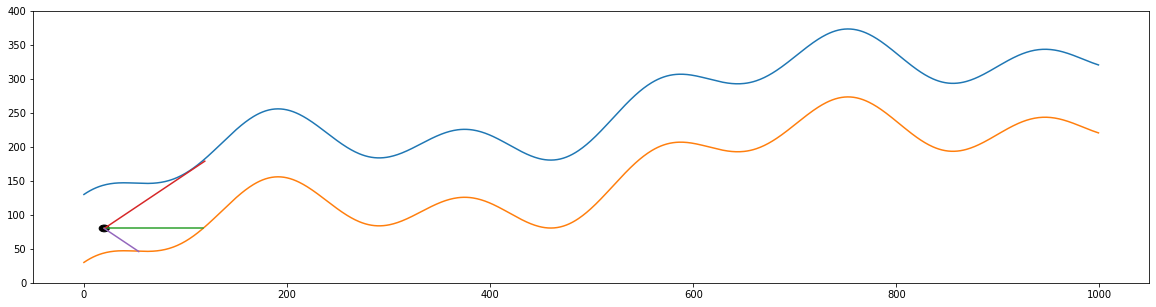

Distance from left wall =  67
Distance from right wall =  35
tavolsagra van most a felsőtől =  50.0
tavolsagra van most az alsótól =  50.0


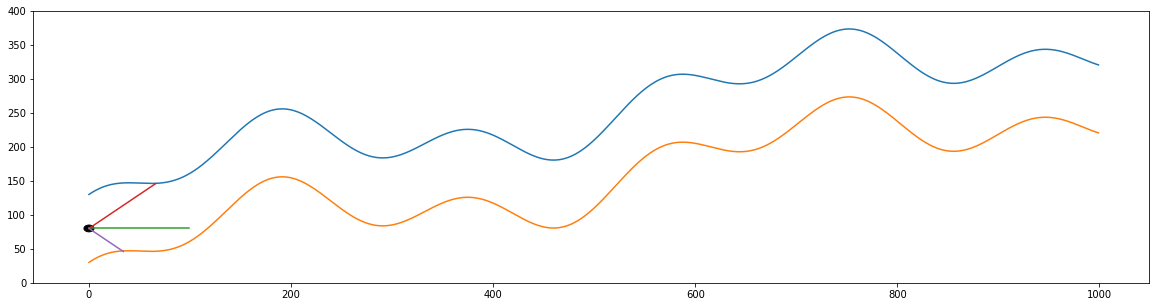

Distance from left wall =  67
Distance from right wall =  34
tavolsagra van most a felsőtől =  51.00554481025708
tavolsagra van most az alsótól =  48.99445518974293


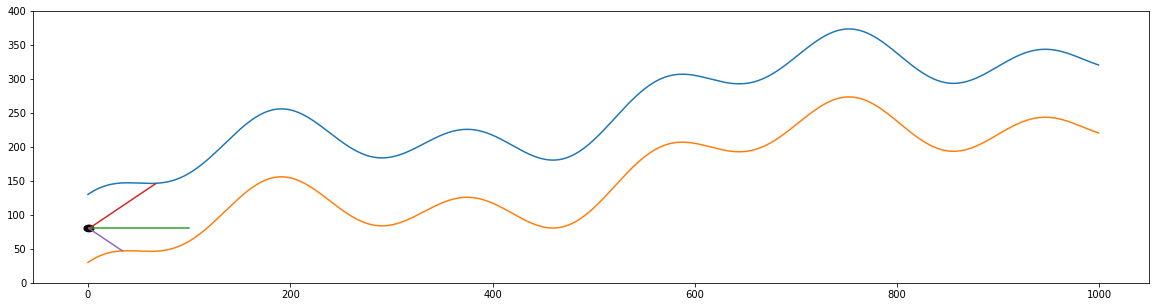

Distance from left wall =  67
Distance from right wall =  34
tavolsagra van most a felsőtől =  51.97770415959371
tavolsagra van most az alsótól =  48.022295840406294


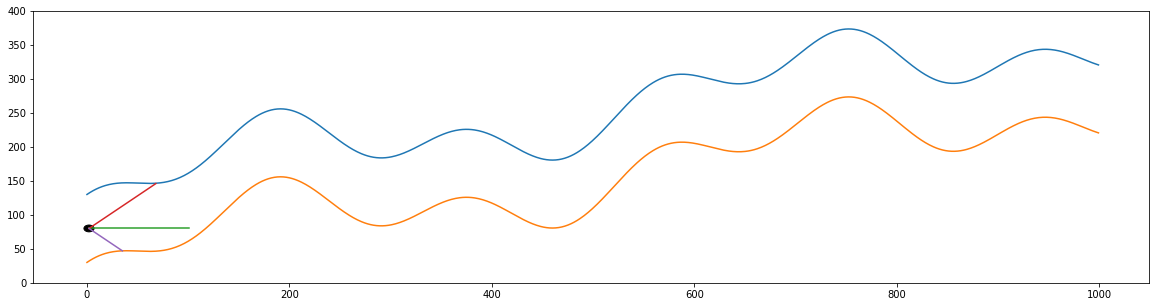

Distance from left wall =  67
Distance from right wall =  34
tavolsagra van most a felsőtől =  52.91645985235181
tavolsagra van most az alsótól =  47.08354014764819


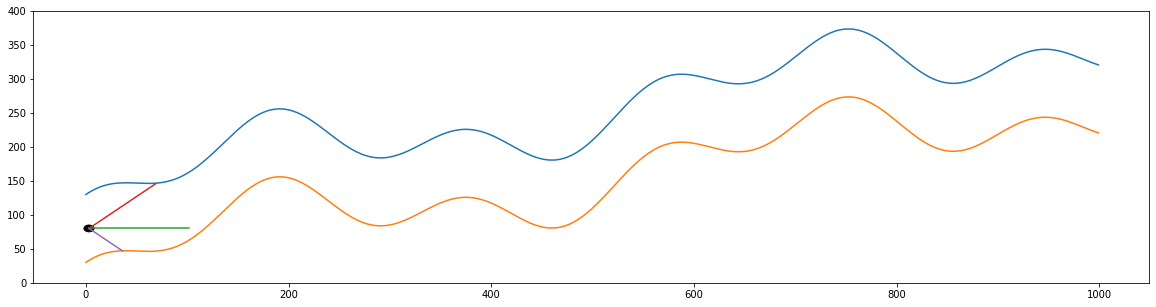

Distance from left wall =  67
Distance from right wall =  34
tavolsagra van most a felsőtől =  53.821830658044206
tavolsagra van most az alsótól =  46.17816934195579


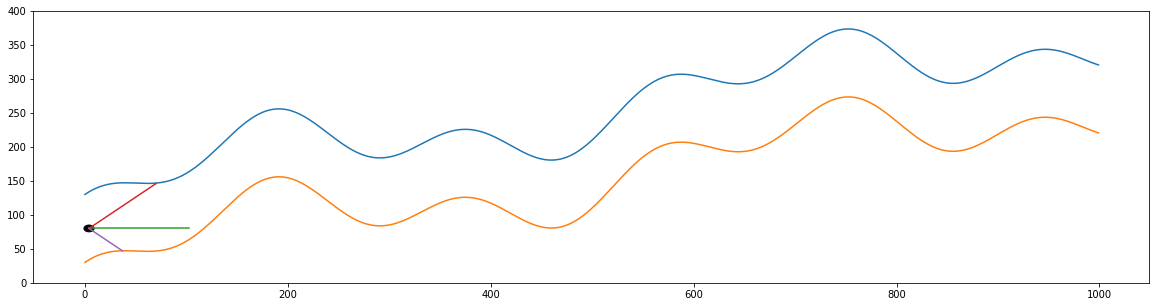

Distance from left wall =  68
Distance from right wall =  34
tavolsagra van most a felsőtől =  54.693872217239715
tavolsagra van most az alsótól =  45.30612778276029


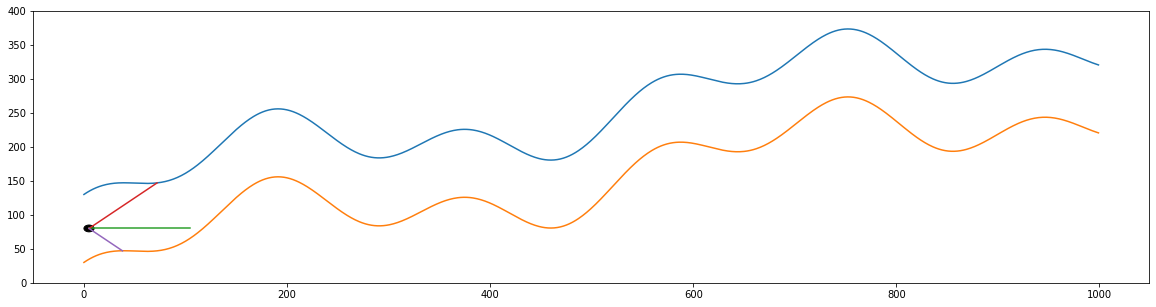

Distance from left wall =  68
Distance from right wall =  34
tavolsagra van most a felsőtől =  55.532676906509494
tavolsagra van most az alsótól =  44.46732309349049


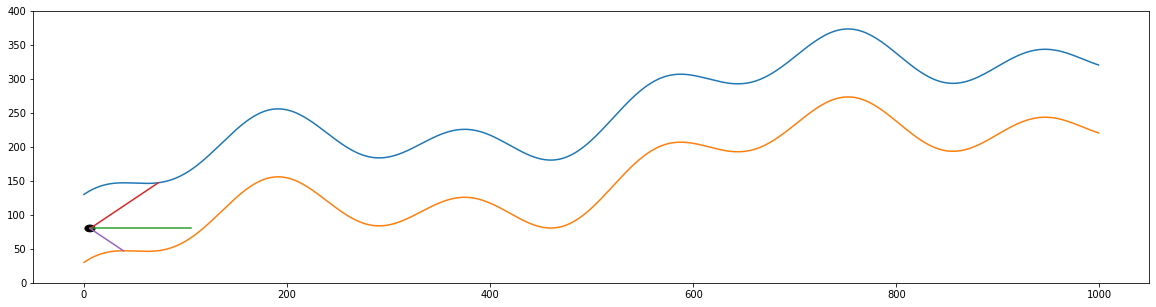

Distance from left wall =  68
Distance from right wall =  34
tavolsagra van most a felsőtől =  56.33837366259391
tavolsagra van most az alsótól =  43.661626337406084


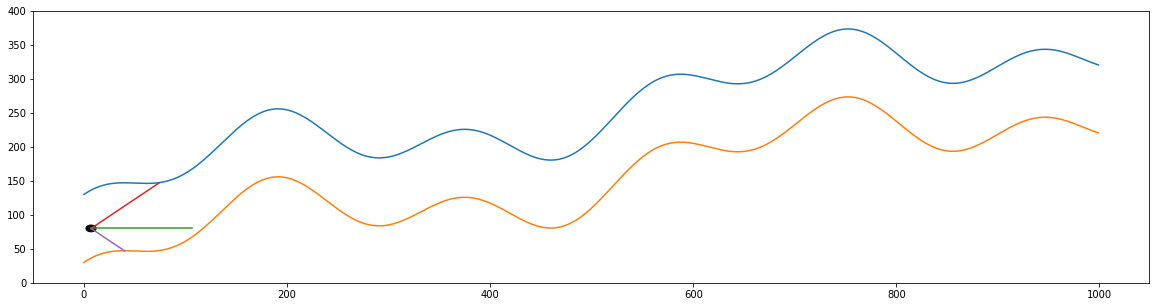

Distance from left wall =  68
Distance from right wall =  34
tavolsagra van most a felsőtől =  57.11112776599293
tavolsagra van most az alsótól =  42.88887223400705


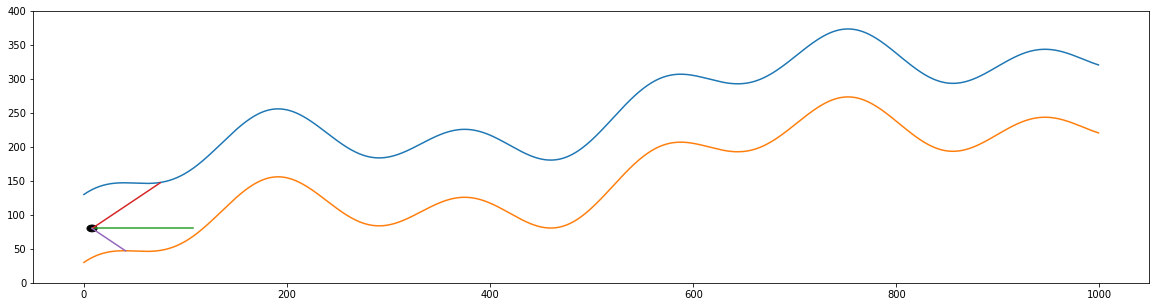

Distance from left wall =  69
Distance from right wall =  34
tavolsagra van most a felsőtől =  57.85114058422994
tavolsagra van most az alsótól =  42.14885941577007


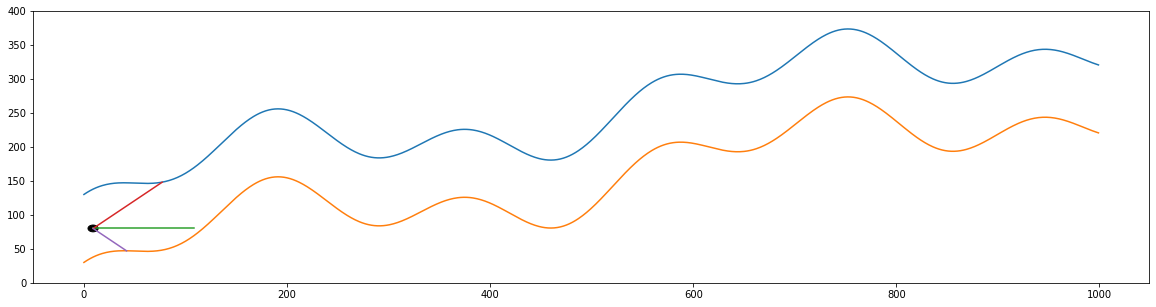

Distance from left wall =  69
Distance from right wall =  34
tavolsagra van most a felsőtől =  58.55864927508179
tavolsagra van most az alsótól =  41.44135072491821


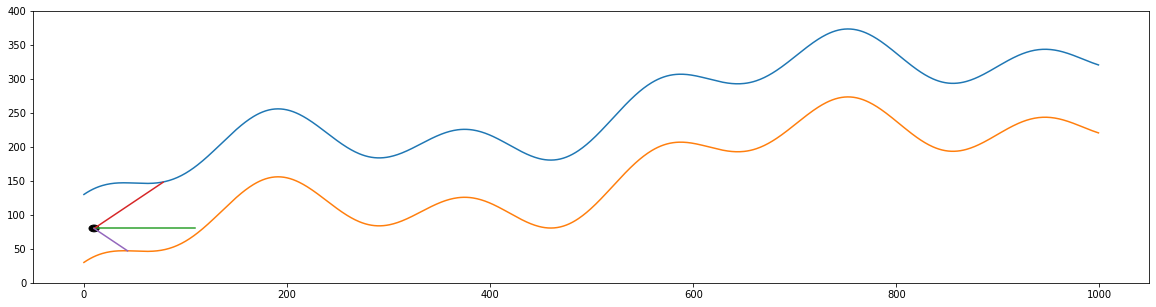

Distance from left wall =  70
Distance from right wall =  34
tavolsagra van most a felsőtől =  59.23392645011421
tavolsagra van most az alsótól =  40.76607354988579


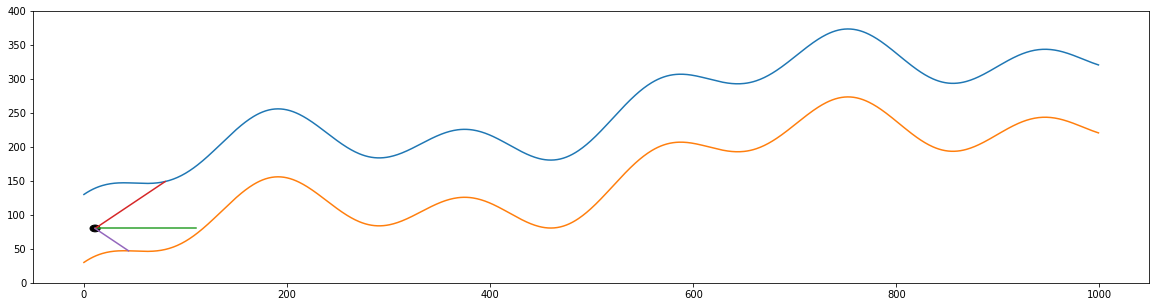

(14, 3)
(14, 1)
Distance from left wall =  70
Distance from right wall =  35
tavolsagra van most a felsőtől =  59.877279798904055
tavolsagra van most az alsótól =  40.12272020109596


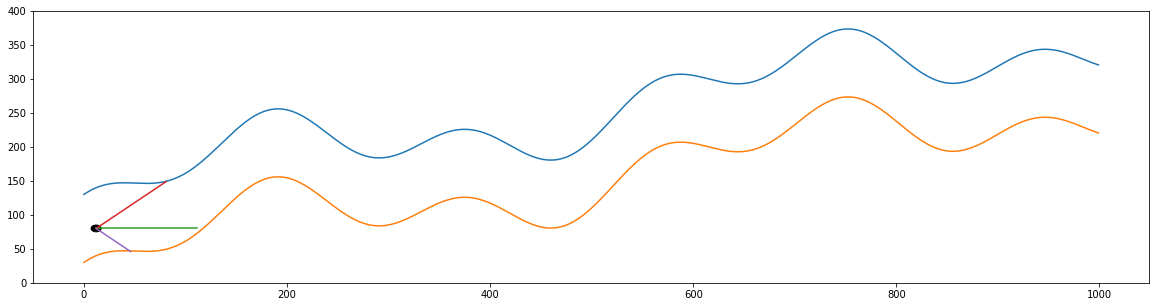

actual _X =  [[ 70 100  35]]
actual predicted =  [[7.54683098]]
Distance from left wall =  71
Distance from right wall =  35
tavolsagra van most a felsőtől =  60.48905167437499
tavolsagra van most az alsótól =  39.510948325624994


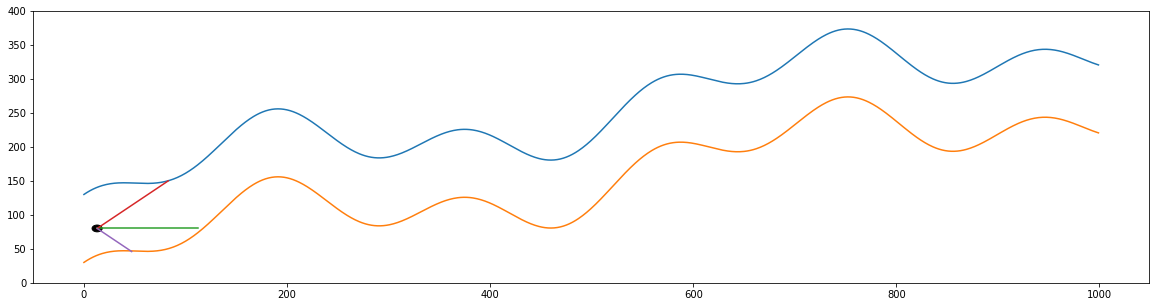

up
Distance from left wall =  70
Distance from right wall =  36
tavolsagra van most a felsőtől =  60.06961863971557
tavolsagra van most az alsótól =  39.93038136028443
81.0
Distance from left wall =  70
Distance from right wall =  36
tavolsagra van most a felsőtől =  60.06961863971557
tavolsagra van most az alsótól =  39.93038136028443


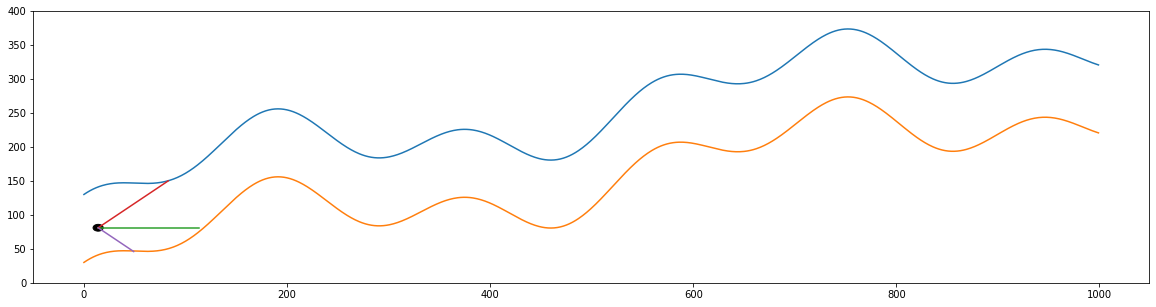

(18, 3)
(18, 1)
Distance from left wall =  71
Distance from right wall =  36
tavolsagra van most a felsőtől =  60.61939097739125
tavolsagra van most az alsótól =  39.38060902260876


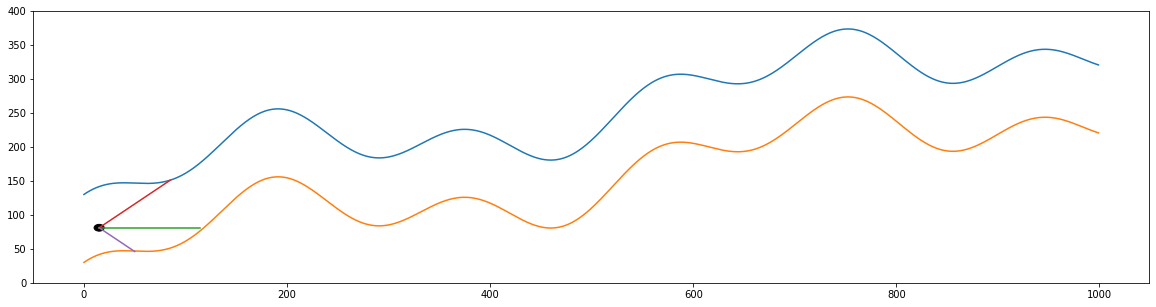

actual _X =  [[ 71 100  36]]
actual predicted =  [[11.71176182]]
Distance from left wall =  72
Distance from right wall =  36
tavolsagra van most a felsőtől =  61.13881216080489
tavolsagra van most az alsótól =  38.8611878391951


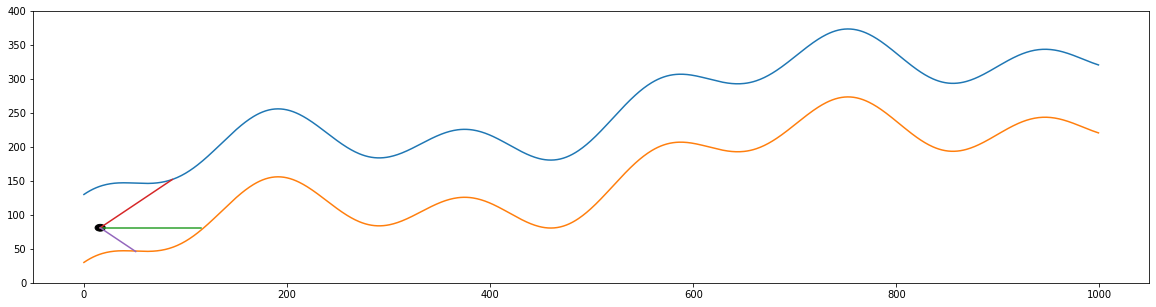

down
Distance from left wall =  76
Distance from right wall =  35
tavolsagra van most a felsőtől =  62.628358289200776
tavolsagra van most az alsótól =  37.37164171079922
80.0
Distance from left wall =  76
Distance from right wall =  35
tavolsagra van most a felsőtől =  62.628358289200776
tavolsagra van most az alsótól =  37.37164171079922


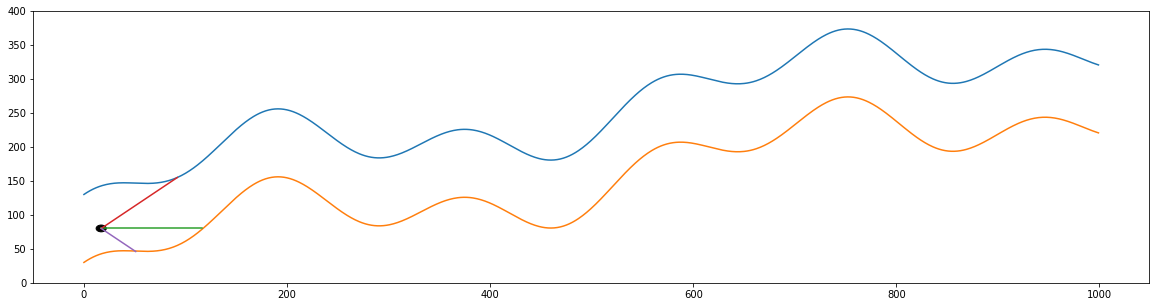

(22, 3)
(22, 1)
Distance center =  100
Distance from left wall =  78
Distance from right wall =  35
tavolsagra van most a felsőtől =  63.088537486448274
tavolsagra van most az alsótól =  36.91146251355174


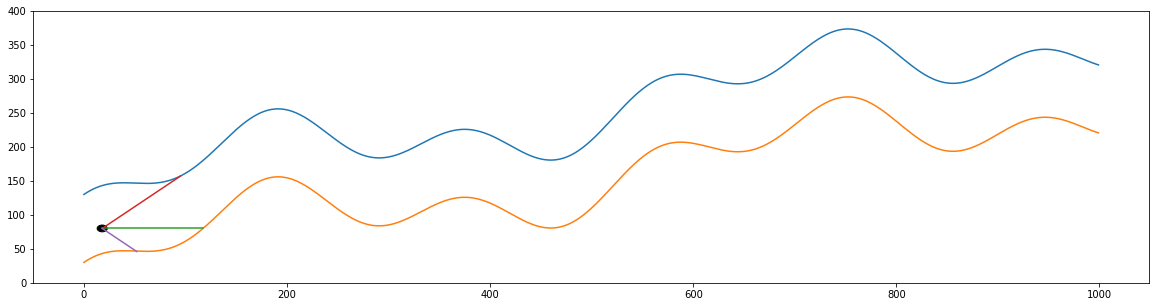

actual _X =  [[ 78 100  35]]
actual predicted =  [[16.88086474]]
Distance center =  99
Distance from left wall =  83
Distance from right wall =  35
tavolsagra van most a felsőtől =  63.519889264381845
tavolsagra van most az alsótól =  36.48011073561817


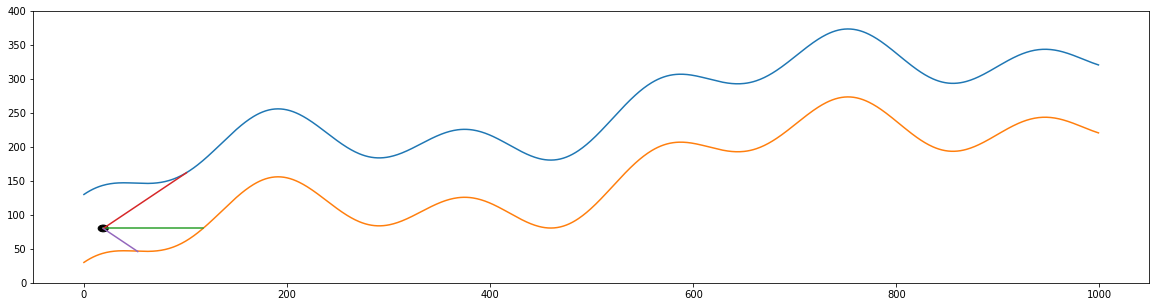

up
Distance from left wall =  82
Distance from right wall =  36
tavolsagra van most a felsőtől =  62.922983851413136
tavolsagra van most az alsótól =  37.07701614858686
81.0
Distance from left wall =  82
Distance from right wall =  36
tavolsagra van most a felsőtől =  62.922983851413136
tavolsagra van most az alsótól =  37.07701614858686


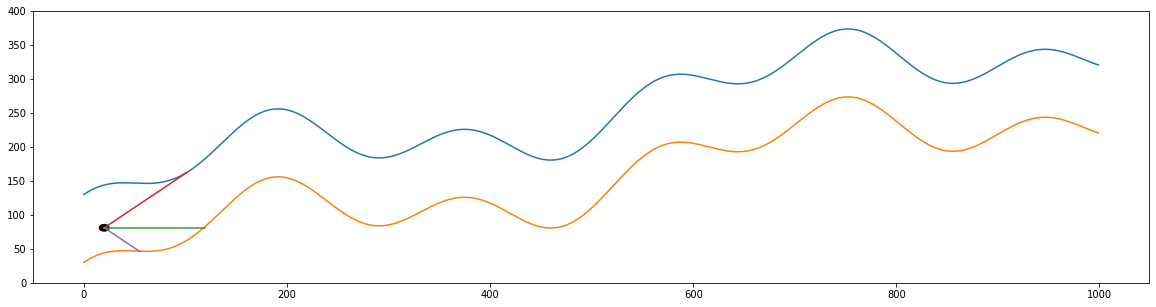

(26, 3)
(26, 1)
Distance from right wall =  36
tavolsagra van most a felsőtől =  63.29842148716904
tavolsagra van most az alsótól =  36.70157851283095


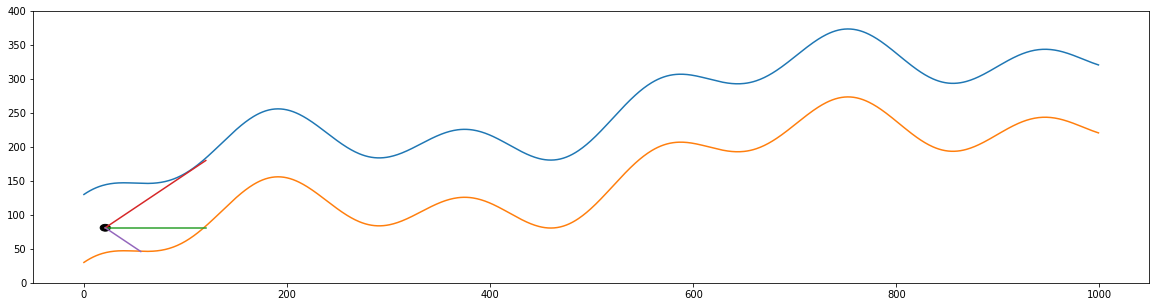

actual _X =  [[100 100  36]]
actual predicted =  [[25.40362439]]
Distance from right wall =  36
tavolsagra van most a felsőtől =  63.64683168394811
tavolsagra van most az alsótól =  36.3531683160519


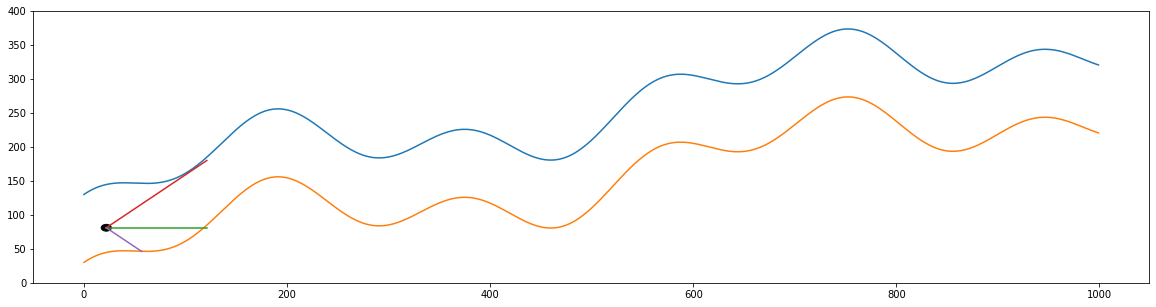

down
Distance center =  95
Distance from right wall =  35
tavolsagra van most a felsőtől =  64.968872455824
tavolsagra van most az alsótól =  35.03112754417599
80.0
Distance center =  95
Distance from right wall =  35
tavolsagra van most a felsőtől =  64.968872455824
tavolsagra van most az alsótól =  35.03112754417599


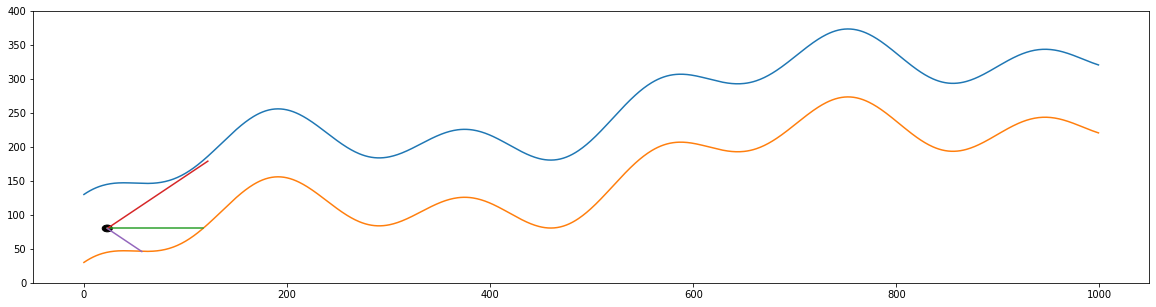

(30, 3)
(30, 1)
Distance center =  94
Distance from right wall =  35
tavolsagra van most a felsőtől =  65.26522951626114
tavolsagra van most az alsótól =  34.73477048373886


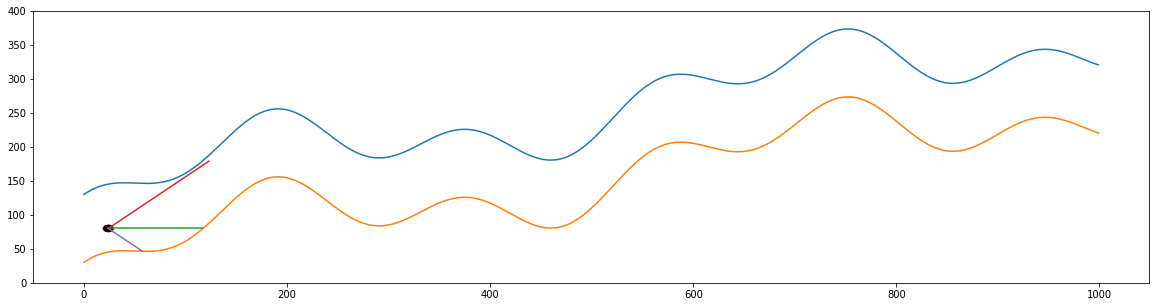

actual _X =  [[100  94  35]]
actual predicted =  [[15.38552262]]
Distance center =  93
Distance from right wall =  35
tavolsagra van most a felsőtől =  65.53661544514148
tavolsagra van most az alsótól =  34.46338455485851


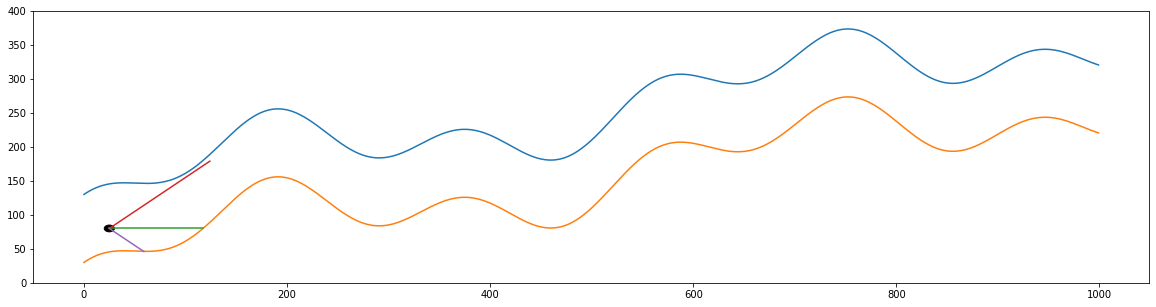

up
Distance from right wall =  36
tavolsagra van most a felsőtől =  64.78376882613719
tavolsagra van most az alsótól =  35.21623117386281
81.0
Distance from right wall =  36
tavolsagra van most a felsőtől =  64.78376882613719
tavolsagra van most az alsótól =  35.21623117386281


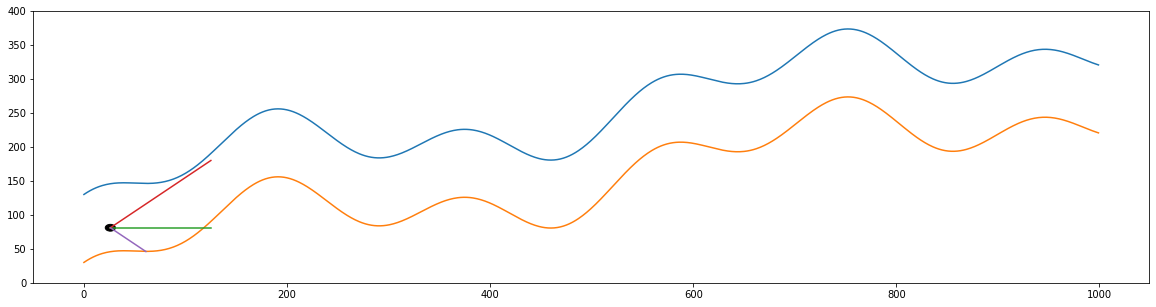

(34, 3)
(34, 1)
Distance from right wall =  36
tavolsagra van most a felsőtől =  65.00745335539489
tavolsagra van most az alsótól =  34.99254664460511


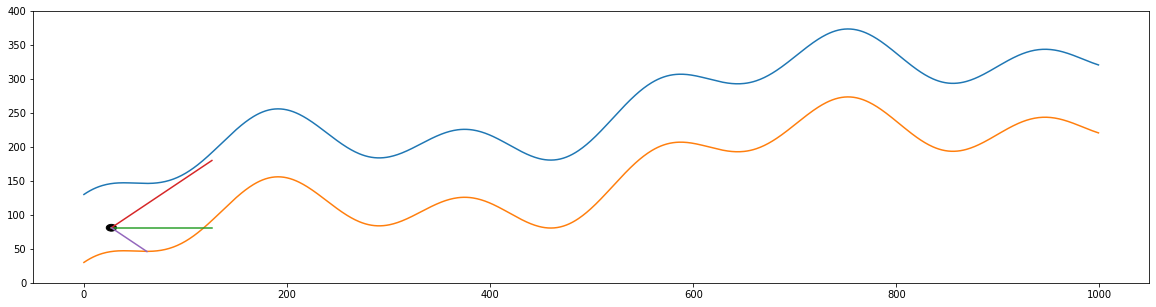

actual _X =  [[100 100  36]]
actual predicted =  [[15.4502104]]
Distance from right wall =  36
tavolsagra van most a felsőtől =  65.20845692253067
tavolsagra van most az alsótól =  34.79154307746931


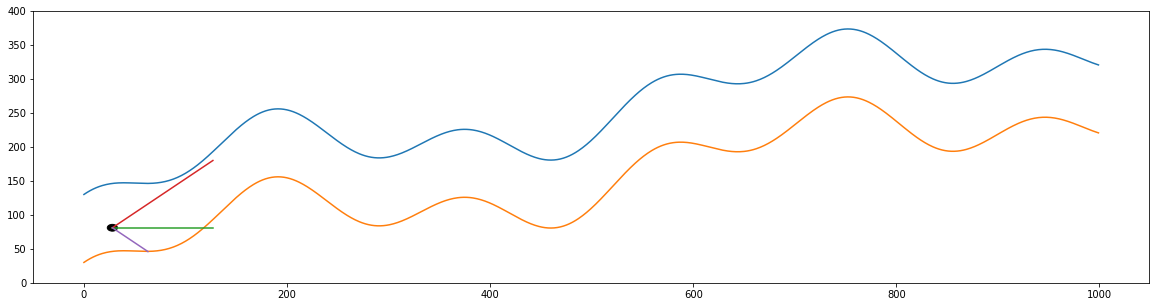

down
Distance center =  89
Distance from right wall =  35
tavolsagra van most a felsőtől =  66.3875906649647
tavolsagra van most az alsótól =  33.61240933503528
80.0


In [147]:
auto.run()

In [ ]:
for i in range(0, 100, 1):
  auto.calculate_distances()
  auto.plot()
  auto.x = i


  # tulajdonképpen itt jön majd a logika miszerint,
  #
  # 1 veszünk egy neurális hálót
  # bemenetek a faltól mért távolságok a szezorok alapján, kimenet a ratio (vagyis, hogy milyen aránban mennyire van a faltól)
  # a ratiót még át kell állítanom úgy, hogy pozitív és negatív értéke is legyen
  #
  # minden lépés után újra tanítjuk a hálót
  # miden második lépésben viszont azt csináljuk, hogy felfelé lépünk egyet az y tengelyen vagy lefele és megnézzük, hogy ennek
  # hatására, hogy változott a szenzoros adat.
  #
  # egy harmadik lépésben pedig azt csináljuk, hogy 50 mérés után
  #
  # kiszámoljuk a szenzoros adatokból a before after adatok alapján, a lineáris regressziós modelt minden egyes metrikára
  #
  # ha megvan ez a modell, akkor
  #
  # 4 lépésben kiszámoljuk, hogy mi lenne a szenzor új értéke 1,2,3,4,5,... stb le, vagy fel lépés esetén
  #
  # 5 mindegyik esetben behelyettesítjük a neurális hálóba és végig nézzük, hogy milyen kimenete lenne (ne feledjük, hogy a középponhoz való közelséget mérjük)
  # azt az megoldást választjuk, ami a legközelebb viszi a középponthoz
  #
  # 6 ténylegesen módosítunk a kocsi y értékén méghozzá annyival amit a rendszer mond

<a name="irodalom"></a>

# Felhasznált irodalom és internetes cimek

Itt gyűjtöttem össze a menet közben összegyűjt okosságokat

[vissza a tartalomhoz](#tartalom)<br>

Scikit-learn - MLPRegressor API
<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html


Fogalmak és probléma meghatározás
<br>
https://www.rubrik.com/blog/architecture/20/12/customized-autoscaling--minimize-your-cloud-cost


https://github.com/kubernetes/autoscaler/blob/master/cluster-autoscaler/FAQ.md#what-are-the-parameters-to-ca

https://arxiv.org/pdf/1608.04030.pdf

Metrikák amivel a szollgáltatás minőségét mérik különböző esetekben
<br>
https://blog.avinetworks.com/autoscaling-metrics

------------

NumPy API Reference Guide
<br>
https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html


Seaborn API Reference Guide
<br>
https://seaborn.pydata.org/examples/pair_grid_with_kde.html

